## In this notebook  the AdaptMap goat genomic data set is analysed

### Plan of action:

### 1) Genotype data format change with PLINK
### 2) SNP data quality control with PLINK
### 3) Principal Component Analysis - PCA


Key cocepts: 

SNP = Single Nucleotide Polymorphisme, this is a small change in the DNA sequence resulting in one nucleotide being changed by another 

PCA = Principle Component Analysis is a statistical technique used to reduce the dimensionality of a dataset while preserving as much variance as possible by transforming the original variables into a new set of uncorrelated variables called principal components.


## Genotype data format change with PLINK

## PLINK format is a standard  format for genotype data it includes the following data types:

fam file type = contains  information on individuals (samples)
bim file type = contains SNP location information 
bed file type : contains the actual genotype data for each individual across the SNPs
map and ped files are extracted from bed file in a binary format
ped file type contains the genotype data 
vcf file = Vatiant Call Format : stores the variants in the sequences of DNA  of specific lengths 
bam file type : stores the entire genome sequence in order , this is binary file

In [1]:
# Clear workspace
rm(list = ls())


In [ ]:
# run PLINK : bped to ped data type
system("plink --bfile ADAPTmap_genotypeTOP_20160222_full --cow --recode --out ADAPTmap_genotypeTOP_20160222_full")

In [ ]:
# run PLINK : bped to vcf data type
system("plink --bfile ADAPTmap_genotypeTOP_20160222_full --cow --recode vcf --out ADAPTmap_genotypeTOP_20160222_full")

In [ ]:
# run PLINK : ped to vcf data type
system("plink --file ADAPTmap_genotypeTOP_20160222_full --cow --recode vcf --out ADAPTmap_genotypeTOP_20160222_full")

 ## SNP data quality control with PLINK

In [2]:
# Set working directory
setwd("/Users/mikae/OneDrive/Bureau/Plink_with_R/PCA_analysis_R")

## Quality control criteria

For the sake of explanations we will use a data set with five individuals each of them genotyped for five SNPs.
The genotypes themselves are in numerical coding, 11 and 22 being the two homozygous, 12 the heterozygous, and 00 coded as missing.
### Missingness per SNP: 0.1 --geno : missing SNPs up to a certain threshold are deleted as in the the example image bello the column for SNP 2 is deleted

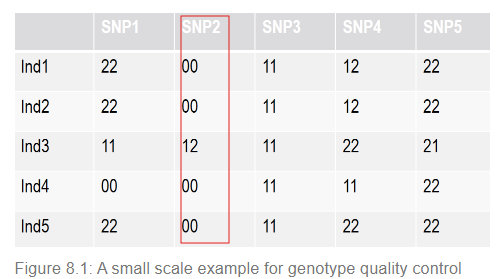


### Missingness per individual: 0.1 --mind : Individuals with too many missing SNP data should be deleted from the dataset in the example image bellow individual 4 is deleted from the dataset

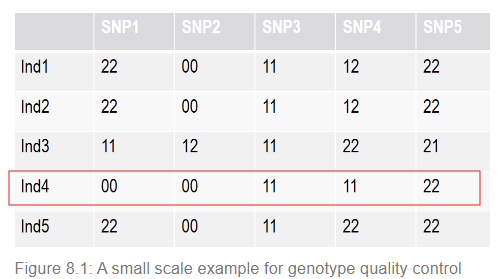

### Minor allele frequency: 0.05 --maf : maf stands for Minor Allele Frequency this QC methods allows to set a threshold for filtering the SNPs with regards to their maf , in the example bello there are a total of 10 alleles 6 of which are "2" 2 being  and 4 of which are "1" 

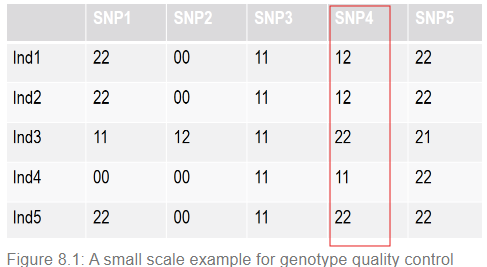


In [4]:
# Run PLINK QC
system("plink --bfile ADAPTmap_genotypeTOP_20160222_full --cow --autosome --geno 0.1 --mind 0.1 --maf 0.05 --nonfounders --allow-no-sex --recode --out ADAPTmap_TOP")

[1] 0

######################################
# Principal Component Analysis - PCA #
######################################

In [5]:
# Genetic distances between individuals
system("plink --cow --allow-no-sex --nonfounders --file ADAPTmap_TOP --distance-matrix --out dataForPCA")


[1] 0

In [6]:
# Load data
dist_populations <- read.table("dataForPCA.mdist", header = FALSE)

In [7]:
# Extract breed names
fam <- data.frame(famids = read.table("dataForPCA.mdist.id")[, 1])


In [19]:

### Extract individual names 
famInd <- data.frame(IID=read.table("dataForPCA.mdist.id")[,2])

In [8]:
# Perform PCA using the cmdscale function
# Time intensive step - takes a few minutes with the 4.5K animals
mds_populations <- cmdscale(dist_populations, eig = TRUE, k = 5)

In [20]:
# Extract the eigen vectors
eigenvec_populations <- cbind(fam, famInd, mds_populations$points)


In [10]:
# Proportion of variation captured by each eigen vector
eigen_percent <- round(((mds_populations$eig) / sum(mds_populations$eig)) * 100, 2)


In [11]:
# Select only the first 5 components
eigen_percent_5 <- eigen_percent[1:5]

In [12]:

# Print the proportion of variation explained by each component
print(eigen_percent_5)


[1] 8.20 5.59 3.34 1.55 1.54


In [13]:
# Visualize the explained variance
explained_variance <- data.frame(Component = 1:length(eigen_percent_5), Variance = eigen_percent_5)


In [14]:
# Load ggplot2 for visualization
library(ggplot2)

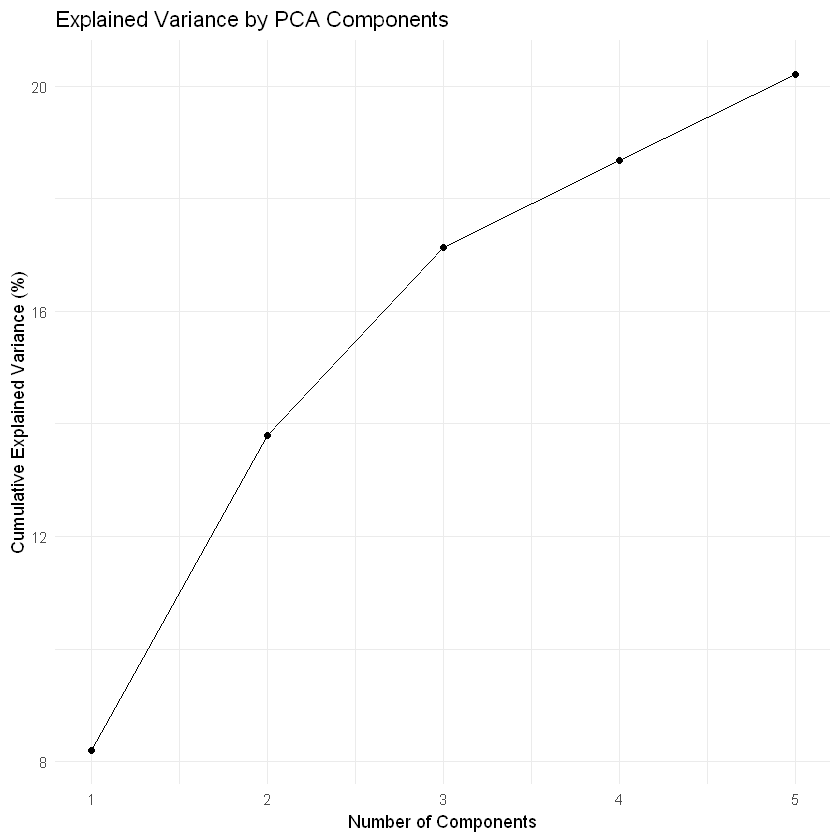

In [15]:
# Plot cumulative explained variance
ggplot(explained_variance, aes(x = Component, y = cumsum(Variance))) +
  geom_line() +
  geom_point() +
  labs(x = 'Number of Components', y = 'Cumulative Explained Variance (%)', title = 'Explained Variance by PCA Components') +
  theme_minimal()


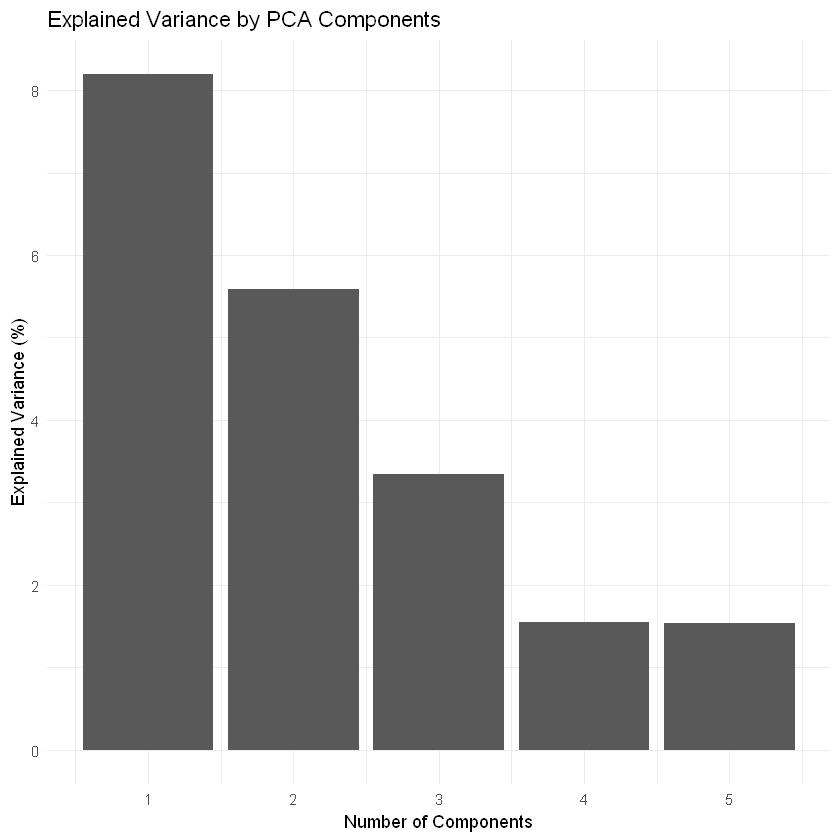

In [16]:
# Plot individual explained variance
ggplot(explained_variance, aes(x = Component, y = Variance)) +
  geom_bar(stat = 'identity') +
  labs(x = 'Number of Components', y = 'Explained Variance (%)', title = 'Explained Variance by PCA Components') +
  theme_minimal()

In [42]:
# Visualize PCA in tidyverse
# Load tidyverse
if (!require("tidyverse")) {
  install.packages("tidyverse", dependencies = TRUE)
  library(tidyverse)
}


In [43]:
# Agrandir le graphique 
options(repr.plot.width=20, repr.plot.height=14)

# # enregistrer le graphique plus grand
# ggsave("PCA_plot.png", width = 30, height = 15)


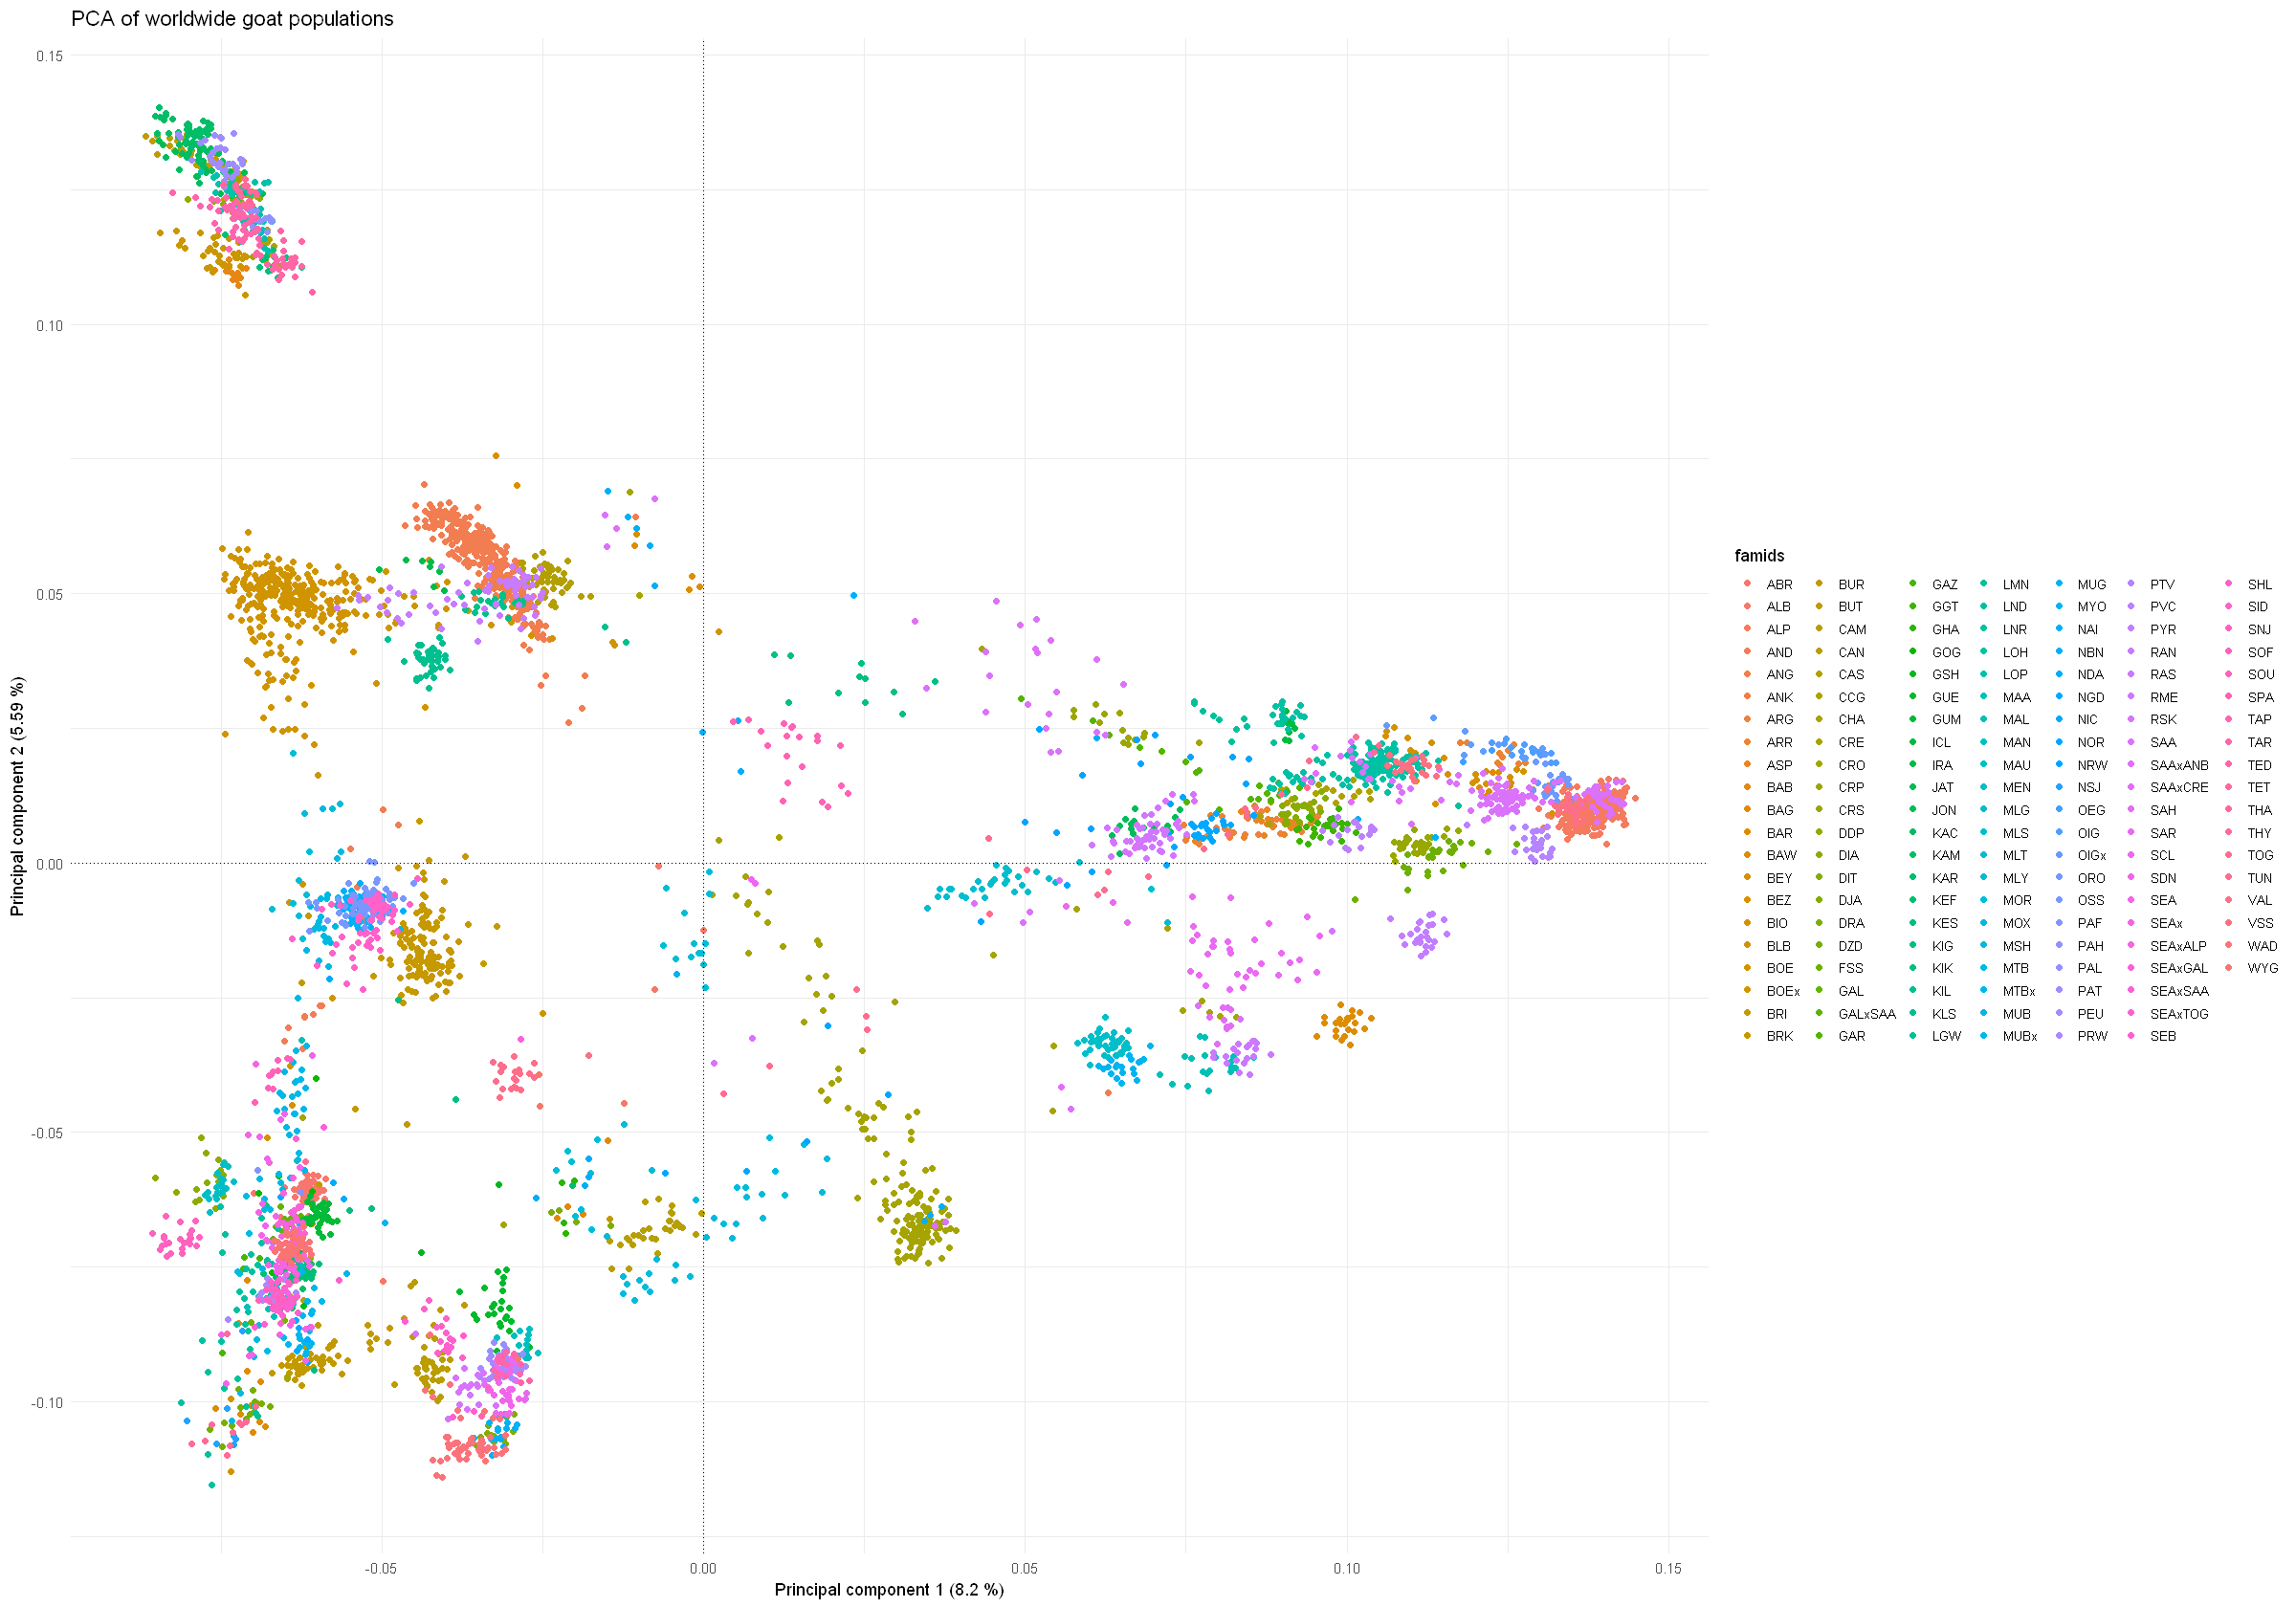

In [44]:
ggplot(data = eigenvec_populations) +
  geom_point(mapping = aes(x = `1`, y = `2`, color = famids), show.legend = TRUE) + 
  geom_hline(yintercept = 0, linetype = "dotted") + 
  geom_vline(xintercept = 0, linetype = "dotted") +
  labs(title = "PCA of worldwide goat populations",
       x = paste0("Principal component 1 (", eigen_percent[1], " %)"),
       y = paste0("Principal component 2 (", eigen_percent[2], " %)")) + 
  theme_minimal() +
  theme(legend.position = "right",  # Position de la légende
        legend.box = "vertical",  # Organisation verticale
        legend.key.size = unit(0.5, "cm"),  # Réduire la taille des clés de légende
        legend.text = element_text(size = 8)) +  # Réduire la taille du texte
  guides(color = guide_legend(ncol = 7))  # Organiser en 2 colonnes
